# A Growth Forecasting Model

## Import Packages

In [649]:
# API Requests for data
import requests

# Data Manipulation and Analysis
import pandas as pd
from pprint import pprint 
import json
from io import StringIO
import numpy as np

# Database Connection
from sqlalchemy import create_engine

# SQL Querying
from sqlalchemy import inspect, text

#  Plotting and Visualization
from plotnine import *
from plotnine.scales import scale_x_date
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import warnings
from plotnine.exceptions import PlotnineWarning


# Regressions and Statistics
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

# File and System Operations
import os
import sys

## Other Setup

In [650]:
pd.set_option('display.max_columns', None) # Display all columns in any given DataFrame

### Import Custom Packages

In [651]:
# Change the wd
sys.path.insert(0,'../src/')

#Import the packages
from macro_utils import sql_queries as sqlq
from macro_utils import functions as macro

## Data Setup and Import

### Load in the Data from Penn World Tables

In [652]:
# Read in the PWT Data
pwt=pd.read_excel('../data/pwt1001.xlsx',sheet_name='Data')



### Data Cleaning

In [653]:
# Select only the relevant columns from pwt
pwt = pwt[["countrycode","country", "year", "rgdpo", "pop", "emp","avh","rgdpna","rnna","rtfpna", "delta"]]

# Add a 'date' column representing the last calendar date of each year in datetime format
pwt['date'] = pd.to_datetime(pwt['year'].astype(str) + '-12-31')

# Add a labour input column
pwt['L'] = pwt['emp'] * pwt['avh']

In [654]:
# Start by focussing on one country in particular first
focus_country = 'USA'
focus_df = pwt[pwt['countrycode'] == focus_country].copy().reset_index(drop=True)

In [655]:
focus_df

,countrycode,country,year,rgdpo,pop,emp,avh,rgdpna,rnna,rtfpna,delta,date,L
0,USA,United States,1950,2475627.50,155.583973,62.814365,1990.144875,2466594.75,10563268.0,NaN,0.032337,1950-12-31,125009.687370
1,USA,United States,1951,2660815.75,158.247704,65.092644,2031.635134,2665368.00,10898386.0,NaN,0.032250,1951-12-31,132244.501971
2,USA,United States,1952,2751933.50,160.980892,65.884354,2027.812612,2773902.75,11258935.0,NaN,0.032258,1952-12-31,133601.123258
3,USA,United States,1953,2878352.50,163.669147,66.820717,2021.450284,2904121.75,11667803.0,NaN,0.032326,1953-12-31,135074.757073
4,USA,United States,1954,2869544.25,166.572976,65.598328,1998.127345,2887745.25,12058041.0,0.651450,0.032339,1954-12-31,131073.812217
...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,USA,United States,2015,18785358.00,320.878310,150.248474,1770.023174,18776158.00,65053556.0,0.992893,0.043622,2015-12-31,265943.281068
66,USA,United States,2016,19095196.00,323.015995,152.396957,1766.744125,19097498.00,65971328.0,0.993724,0.044137,2016-12-31,269246.429191
67,USA,United States,2017,19542980.00,325.084756,154.672318,1763.726676,19542980.00,66940280.0,1.000000,0.044633,2017-12-31,272799.692425
68,USA,United States,2018,20155260.00,327.096265,156.675903,1774.703811,20128580.00,68005632.0,1.008166,0.045239,2018-12-31,278053.322733


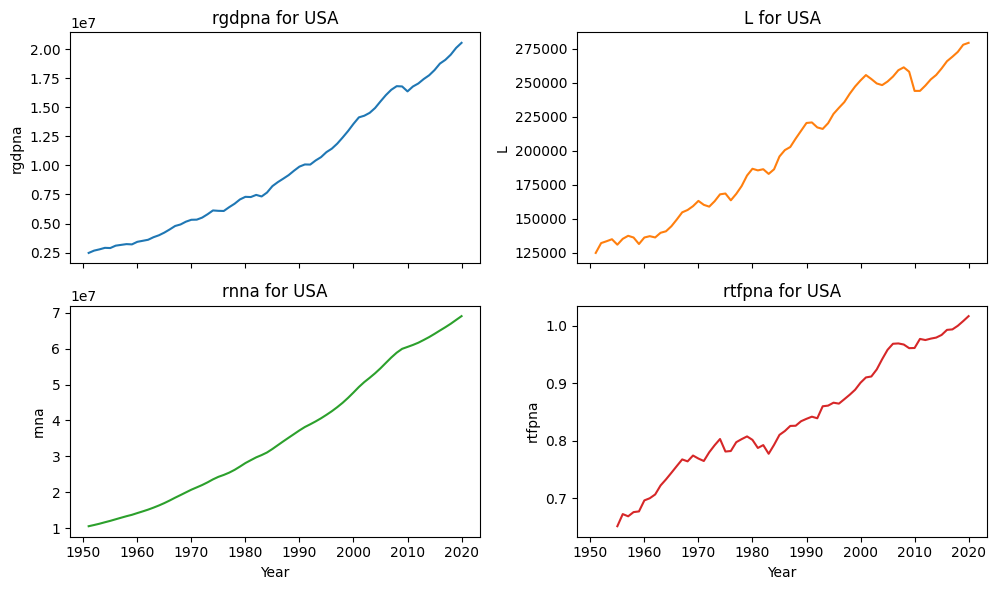

In [656]:
# Plot rgdpna emp and rnna over time
fig, axes = plt.subplots(2, 2, figsize=(10, 6), sharex=True)

# Plot rgdpna
axes[0, 0].plot(focus_df['date'], focus_df['rgdpna'], color='tab:blue')
axes[0, 0].set_title(f'rgdpna for {focus_country}')
axes[0, 0].set_ylabel('rgdpna')

# Plot L
axes[0, 1].plot(focus_df['date'], focus_df['L'], color='tab:orange')
axes[0, 1].set_title(f'L for {focus_country}')
axes[0, 1].set_ylabel('L')

# Plot rnna
axes[1, 0].plot(focus_df['date'], focus_df['rnna'], color='tab:green')
axes[1, 0].set_title(f'rnna for {focus_country}')
axes[1, 0].set_ylabel('rnna')
axes[1, 0].set_xlabel('Year')

# Plot rtfpna
axes[1, 1].plot(focus_df['date'], focus_df['rtfpna'], color='tab:red')
axes[1, 1].set_title(f'rtfpna for {focus_country}')
axes[1, 1].set_ylabel('rtfpna')
axes[1, 1].set_xlabel('Year')

plt.tight_layout()
plt.show()

## Use this Model for Forecasting

### Set up the Model Equations

In [657]:
# Set parameters
delta = 0.1 # default depreciation rate
alpha = 0.3 # output elasticity of capital
gamma = 0.2 # default savings rate
n = 0.05
g_a = 0.02
A = 1.0

In [658]:
# Define functions that take our estimated structural parameters,
# current endogenous variables, and compute those for the next period

# compute output
def f(K, A, L):
    Y = A * K**(alpha) * (L) ** (1 - alpha)
    return Y

# compute next period's capital
def K_next(K,A, L, delta):
    K_next = gamma * f(K, A, L) + (1 - delta) * K
    return K_next

In [659]:
# Solve steady state k tilde using analytical solution
k_tilde_star = (gamma / delta + n + g_a)**(1. / (1 - alpha))

#### Find the normalising constant with which capital accumulation relates to that predicted by a cobb douglas production function and a depreciation rate.

In [660]:


# Predict the capital stock based on capital in the last period
focus_df['k_pred'] = K_next(focus_df['rnna'].shift(1), focus_df['rtfpna'].shift(1), focus_df['emp'].shift(1)*focus_df['avh'].shift(1), focus_df['delta'].shift(1))

# Divide the actual change in capital stock by the predicted change to
# get the scaling factor s
s = (focus_df['rnna'] / focus_df['k_pred'])

# since there is no general downward trend in p, just take the mean
focus_df['s'] = s.mean()



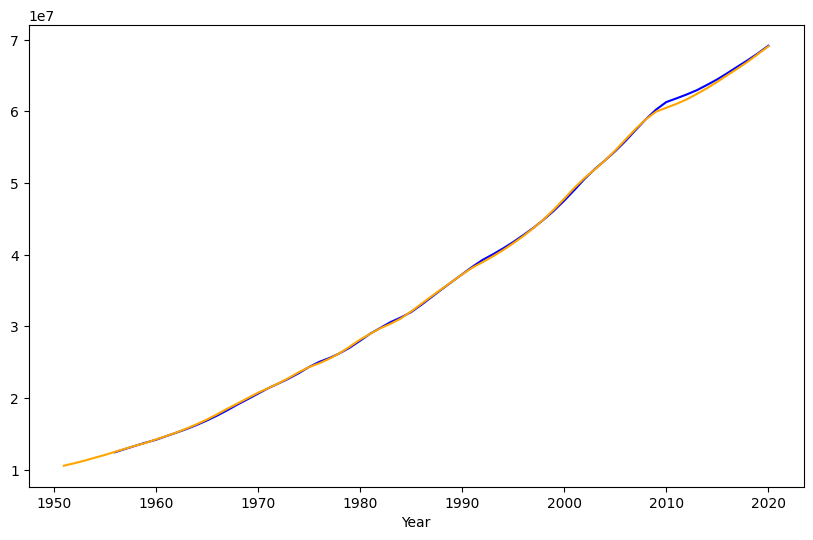

In [661]:
# plot rnna and k_pred on the same graph
plt.figure(figsize=(10, 6))
plt.plot(focus_df['date'], focus_df['k_pred']*s.mean(), label='k_pred', color='blue')
plt.plot(focus_df['date'], focus_df['rnna'], label='k', color='orange')   
plt.xlabel('Year')
plt.show()

#### Find the normalising constant with which real output relates to that predicted by the cobb douglas production function

In [662]:


def add_cobb_douglas_normalisation(df=None,):
    """
    Adds the time path of output predicted by the Cobb-Douglas production function,
    computes the normalising constant p, fits a linear trend, and adds the predicted
    p values as a new column to the dataframe.
    """
    if df is None:
        df = focus_df

    # Find the time path of output if predicted by the cobb douglas production function
    df['Y_cd'] = f(df['rnna'], df['rtfpna'], df['emp'] * df['avh'])
    # Divide the real output by the output predicted by the cobb douglas production function
    # whenever not null
    df["p"] = df['rgdpna'] / df['Y_cd']
    valid_bool = (df["p"]).notna()
    p_valid = df.loc[valid_bool, "p"]
    valid_idx = df.index[valid_bool]  # Only use time indices where p is valid

    # assume p follows a linear additive trend throughout time in order to predict future values of p
    # fit a linear regression model to the data
    X = sm.add_constant(valid_idx)  # Add a constant term for the intercept
    model = sm.OLS(p_valid, X).fit()

    # Predict future values of p using the fitted model
    X_full = sm.add_constant(df.index)  # Add a constant term for the intercept
    # Add this as a new column to the df
    df['p_pred'] = model.predict(X_full)
    
     

    return {"df": df, "model": model}

focus_df = add_cobb_douglas_normalisation(focus_df)["df"]

In [663]:
focus_df.index

RangeIndex(start=0, stop=70, step=1)

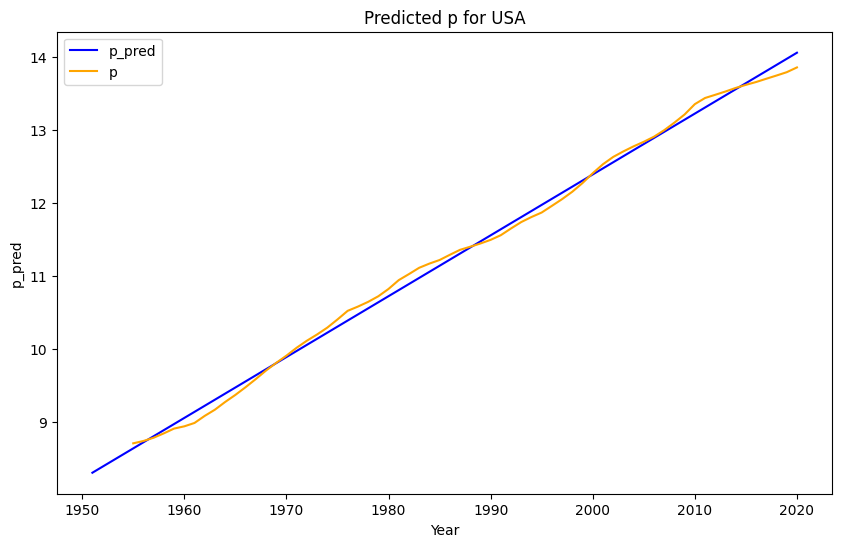

In [664]:
# plot p_pred from focus_df
plt.figure(figsize=(10, 6))
plt.plot(focus_df['date'], focus_df['p_pred'], label='p_pred', color='blue')
plt.plot(focus_df['date'], focus_df['p'], label='p', color='orange')
plt.xlabel('Year')
plt.ylabel('p_pred')
plt.title(f'Predicted p for {focus_country}')
plt.legend()
plt.show()

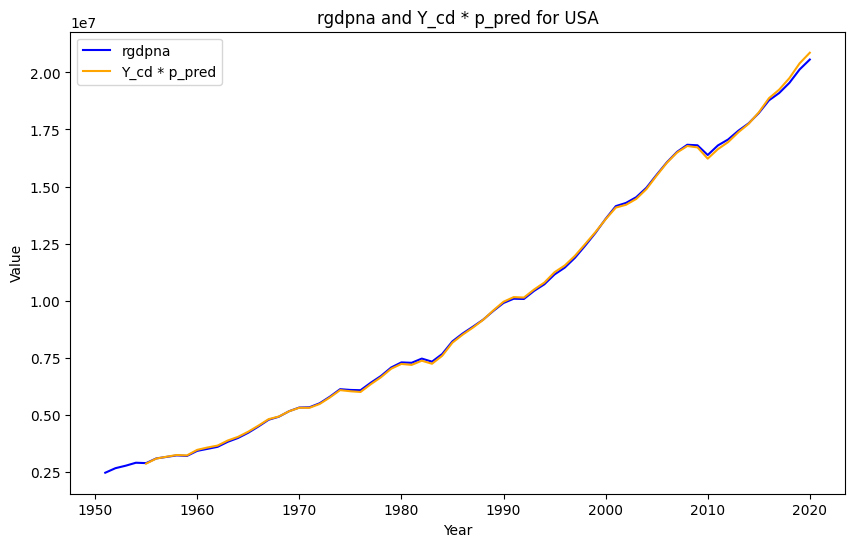

In [665]:
# Plot rgdpna and Y_cd * p_pred on the same graph
plt.figure(figsize=(10, 6))
plt.plot(focus_df['date'], focus_df['rgdpna'], label='rgdpna', color='blue')
plt.plot(focus_df['date'], focus_df['Y_cd'] * focus_df['p_pred'], label='Y_cd * p_pred', color='orange')
plt.title(f'rgdpna and Y_cd * p_pred for {focus_country}')
plt.xlabel('Year')
plt.ylabel('Value')
plt.legend()
plt.show()


### Forecast from 1990 Onwards

In [666]:
# Get the index  of the 1990 date
start_date = pd.to_datetime('1990-12-31')
start_idx = focus_df.index[focus_df['date'] == start_date][0]
print(start_idx)

40


#### Set up the Baseline Paths

In [667]:
def add_paths(df = focus_df, 
              start_idx = start_idx, # Define start index of the observation from which to forecast from
              T = 10, # set time horizon for forecast
              W=20, # set estimation window for the past
              j = 1 # the index of which rolling window number this is
              ):   

    # Get the index range for the estimation window and the forecast period
    idx_range = range(start_idx - W, start_idx + T)
    print(idx_range)
    # Ensure indices are within bounds
    idx_range = [i for i in idx_range if i >= df.index.min() and i <= df.index.max()]

    # Get the paths for the exogenous variables

    # Let's assume that we accurately forecast tfp:
    # Create A_path_j using the 'rtfpna' values from the df
    df.loc[idx_range, f'A_path_{j}'] = df.loc[idx_range, 'rtfpna']

    # Let's assume we also accurately forecast labour input, which is the product of employment and average hours worked
    df.loc[idx_range, f'L_path_{j}'] = df.loc[idx_range, 'L']

    # Also assume accurate forecasting of the depreciation rate
    df.loc[idx_range, f'delta_path_{j}'] = df.loc[idx_range, 'delta']

    # get the path for the normalising constant for capital
    df.loc[idx_range, f's_path_{j}'] = df.loc[idx_range, 's']

    # Get the path for the normalising constant for output -> estimate based on estimation window
    model = add_cobb_douglas_normalisation(df.loc[idx_range[:W],:])["model"]
    # Predict future values of p using the fitted model
    X_full = sm.add_constant(idx_range[W:])  # Add a constant term for the intercept
    # Add this as a new column to the df
    df.loc[idx_range[W:], f'p_path_{j}'] = model.predict(X_full)
    #df.loc[idx_range[:W], f'p_path_{j}'] = p_pred

    # Find the factor by which to scale up cobb doubglas output to match actual output
    #p = (df.loc[idx_range[:W], 'rgdpna'] / df.loc[idx_range[:W], 'Y_cd']).mean()
    #df.loc[idx_range[:W], f'p_path_{j}'] = p

    # Create a default path for the endogenous variables, capital and output
    # Create a column for the forecast K_path_j and fill with NaN for the entire period
    df[f'K_path_{j}']  = np.nan

    # set the starting value for the forecast K_path_j to be its actual value at the start date
    df.loc[start_idx, f'K_path_{j}']  =  df.loc[start_idx, 'rnna'] 

    # Create Y_path_j and fill with observed rgdpna for the same periods (first 10 values)
    df.loc[idx_range, f'Y_path_{j}'] = np.nan # initialise array for time path of output
    #
    df.loc[start_idx, f'Y_path_{j}'] = df.loc[start_idx, 'rgdpna']

    return df


In [668]:
paths_df = add_paths(focus_df)
paths_df.loc[start_idx:, :].head()

range(20, 50)


,countrycode,country,year,rgdpo,pop,emp,avh,rgdpna,rnna,rtfpna,delta,date,L,k_pred,s,Y_cd,p,p_pred,A_path_1,L_path_1,delta_path_1,s_path_1,p_path_1,K_path_1,Y_path_1
40,USA,United States,1990,9978170.0,252.120309,123.046021,1795.567910,10087555.0,38181148.0,0.841929,0.034678,1990-12-31,220937.485849,3.612694e+07,1.060172,872606.761873,11.560253,11.641596,0.841929,220937.485849,0.034678,1.060172,11.677844,38181148.0,10087555.0
41,USA,United States,1991,9939456.0,254.539370,121.567062,1787.337817,10076635.0,38943580.0,0.839172,0.034791,1991-12-31,217281.407833,3.703163e+07,1.060172,864763.766230,11.652471,11.724944,0.839172,217281.407833,0.034791,1.060172,11.757599,NaN,NaN
42,USA,United States,1992,10301173.0,256.990613,121.797005,1774.882852,10431579.0,39749632.0,0.860029,0.034890,1992-12-31,216175.415105,3.776163e+07,1.060172,888540.670484,11.740126,11.808292,0.860029,216175.415105,0.034890,1.060172,11.837354,NaN,NaN
43,USA,United States,1993,10602463.0,259.532129,123.120697,1789.954717,10718744.0,40619356.0,0.861171,0.035005,1993-12-31,220380.472358,3.854046e+07,1.060172,907675.299022,11.809007,11.891640,0.861171,220380.472358,0.035005,1.060172,11.917109,NaN,NaN
44,USA,United States,1994,11054640.0,262.241196,125.689980,1807.827339,11150584.0,41576888.0,0.866267,0.035173,1994-12-31,227225.781313,3.937900e+07,1.060172,939350.241823,11.870529,11.974988,0.866267,227225.781313,0.035173,1.060172,11.996864,NaN,NaN


#### Simulate Paths Forward

In [669]:
def simulate_forward_cd(df = paths_df,
                        start_idx = start_idx, # index of the start date in the DataFrame
                        T = 10, # set time horizon for forecast
                        W=20, # set estimation window for the past
                        j = 1 # the index of which rolling window number this is
                        ):
    """
    Simulates the forward paths of output and capital based on the Cobb-Douglas production function
    and the paths of the exogenous variables.
    """
    # Loop over the time horizon over which we want to simulate the paths
    for t in range(start_idx, start_idx + T, 1):
        df.loc[t, f"Y_path_{j}"] = df.loc[t, f"p_path_{j}"] * f(df.loc[t, f"K_path_{j}"], df.loc[t, f"A_path_{j}"], df.loc[t, f"L_path_{j}"])  # compute today's output
        df.loc[t + 1, f"K_path_{j}"] = df.loc[t, f"s_path_{j}"] * K_next(df.loc[t, f"K_path_{j}"], df.loc[t, f"A_path_{j}"], df.loc[t, f"L_path_{j}"], df.loc[t, f"delta_path_{j}"])  # compute next period's capital

    # loop above does not compute output in the last period, so doing this now
    df.loc[start_idx + T, f"Y_path_{j}"] = df.loc[start_idx + T, f"p_path_{j}"] * f(df.loc[start_idx + T, f"K_path_{j}"], df.loc[start_idx + T, f"A_path_{j}"], df.loc[start_idx + T, f"L_path_{j}"])

    # return the DataFrame with the new paths
    return df


In [670]:
forward_df = simulate_forward_cd(paths_df,start_idx)
forward_df.loc[start_idx:, :].head()

,countrycode,country,year,rgdpo,pop,emp,avh,rgdpna,rnna,rtfpna,delta,date,L,k_pred,s,Y_cd,p,p_pred,A_path_1,L_path_1,delta_path_1,s_path_1,p_path_1,K_path_1,Y_path_1
40,USA,United States,1990,9978170.0,252.120309,123.046021,1795.567910,10087555.0,38181148.0,0.841929,0.034678,1990-12-31,220937.485849,3.612694e+07,1.060172,872606.761873,11.560253,11.641596,0.841929,220937.485849,0.034678,1.060172,11.677844,3.818115e+07,1.019017e+07
41,USA,United States,1991,9939456.0,254.539370,121.567062,1787.337817,10076635.0,38943580.0,0.839172,0.034791,1991-12-31,217281.407833,3.703163e+07,1.060172,864763.766230,11.652471,11.724944,0.839172,217281.407833,0.034791,1.060172,11.757599,3.925989e+07,1.019225e+07
42,USA,United States,1992,10301173.0,256.990613,121.797005,1774.882852,10431579.0,39749632.0,0.860029,0.034890,1992-12-31,216175.415105,3.776163e+07,1.060172,888540.670484,11.740126,11.808292,0.860029,216175.415105,0.034890,1.060172,11.837354,4.035795e+07,1.056600e+07
43,USA,United States,1993,10602463.0,259.532129,123.120697,1789.954717,10718744.0,40619356.0,0.861171,0.035005,1993-12-31,220380.472358,3.854046e+07,1.060172,907675.299022,11.809007,11.891640,0.861171,220380.472358,0.035005,1.060172,11.917109,4.148279e+07,1.088534e+07
44,USA,United States,1994,11054640.0,262.241196,125.689980,1807.827339,11150584.0,41576888.0,0.866267,0.035173,1994-12-31,227225.781313,3.937900e+07,1.060172,939350.241823,11.870529,11.974988,0.866267,227225.781313,0.035173,1.060172,11.996864,4.263307e+07,1.135439e+07


In [671]:
idx_range

slice(np.int64(38), np.int64(50), None)

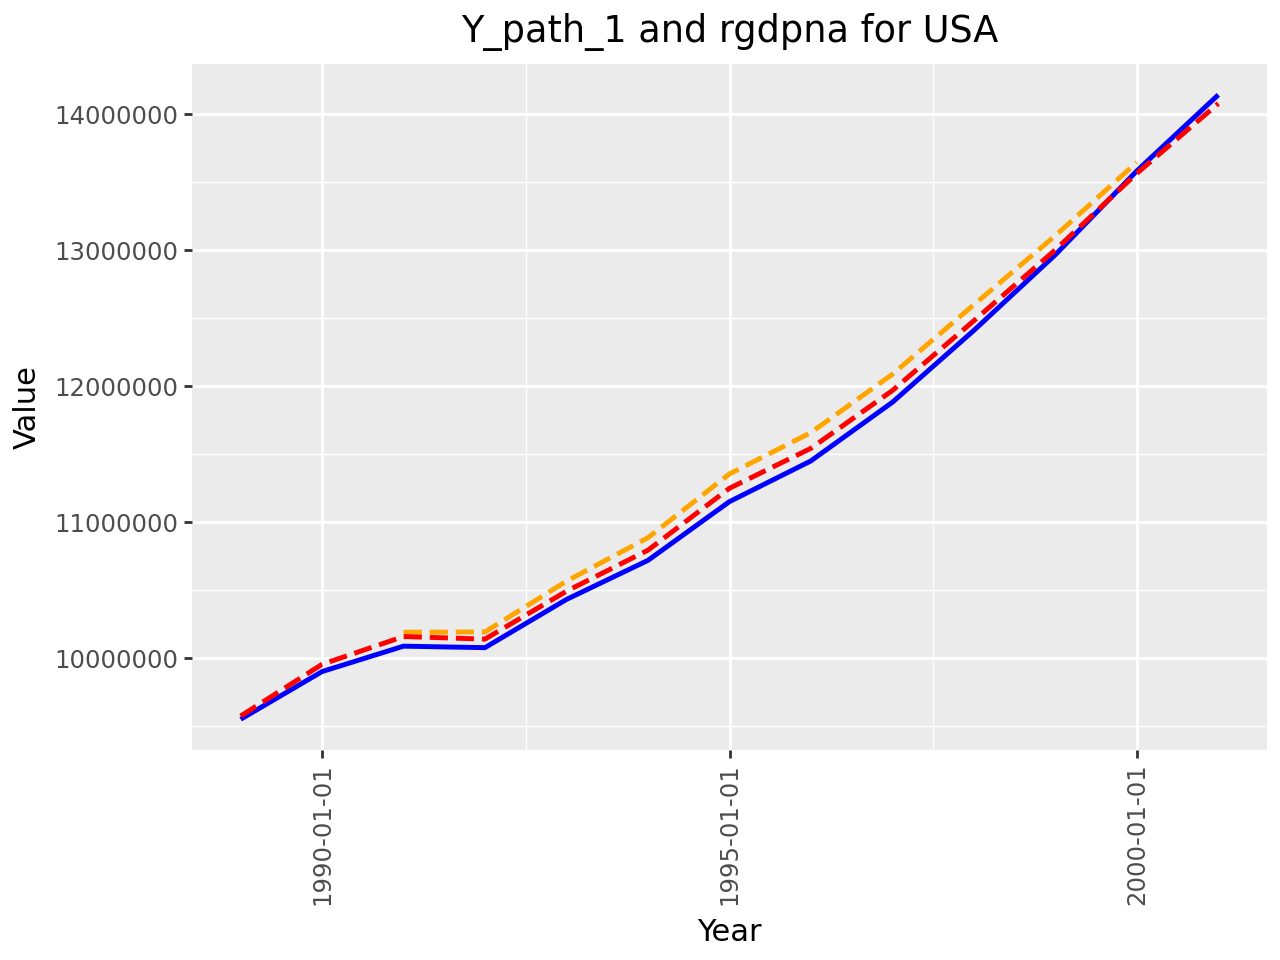

In [672]:
# Set j and index range
j = 1
idx_range = slice(start_idx - 2, start_idx + 10)

# select the right values to plot
plot_df = forward_df.loc[idx_range,:].copy()
plot_df['Y_cd_p_pred'] = plot_df['Y_cd'] * plot_df['p_pred']

#plot_df.loc[:,'Y_cd_p_pred'] = plot_df.loc[:,'Y_cd'] * plot_df.loc[:,'p_pred']

# Plot
plot = (
    ggplot(plot_df, aes(x='date')) +
    # Line 1: Y_path_j
    geom_line(
        aes(y=f'Y_path_{j}'),
        color='orange',
        size=1,
        linetype='dashed'
    ) +

    # Line 2: rgdpna
    geom_line(
        aes(y='rgdpna'),
        color='blue',
        size=1,
        linetype='solid'
    ) +

    # Line 3: Y_cd * p_pred
    geom_line(
        aes(y='Y_cd_p_pred'),
        color='red',
        size=1,
        linetype='dashed'
    ) +
    labs(
        title=f'Y_path_{j} and rgdpna for {focus_country}',
        x='Year',
        y='Value',
        color='Variable',
        linetype='Variable'
    ) +
    theme(
        axis_text_x=element_text(rotation=90, ha='center')
    ) +
    guides(linetype=None)
)

display(plot)
warnings.filterwarnings('ignore', category=PlotnineWarning)

### Forecast over Multiple 10 Year Rolling Windows

In [673]:
# Get the indices for the last year and each valid 10th year before (20 years of prior data)

# Sort years and get list
years = sorted(focus_df['year'].unique())
last_year = years[-1]

# Start from last_year and go back in steps of 10
candidates = list(range(last_year, years[0] + 19, -10))  # Only go as far back as possible to still have 20 years

# Filter to only those years with at least 20 years of prior data
valid_years = [y for y in candidates if (y - 20) in years]

# Get the indices of those years
forecast_indices = focus_df[focus_df['year'].isin(valid_years)].index

In [674]:
forecast_indices

Index([29, 39, 49, 59, 69], dtype='int64')

In [675]:
focus_df.tail()

,countrycode,country,year,rgdpo,pop,emp,avh,rgdpna,rnna,rtfpna,delta,date,L,k_pred,s,Y_cd,p,p_pred,A_path_1,L_path_1,delta_path_1,s_path_1,p_path_1,K_path_1,Y_path_1
65,USA,United States,2015,18785358.0,320.878310,150.248474,1770.023174,18776158.0,65053556.0,0.992893,0.043622,2015-12-31,265943.281068,6.162497e+07,1.060172,1.374789e+06,13.657486,13.725299,NaN,NaN,NaN,NaN,NaN,NaN,NaN
66,USA,United States,2016,19095196.0,323.015995,152.396957,1766.744125,19097498.0,65971328.0,0.993724,0.044137,2016-12-31,269246.429191,6.249075e+07,1.060172,1.393725e+06,13.702485,13.808648,NaN,NaN,NaN,NaN,NaN,NaN,NaN
67,USA,United States,2017,19542980.0,325.084756,154.672318,1763.726676,19542980.0,66940280.0,1.000000,0.044633,2017-12-31,272799.692425,6.333830e+07,1.060172,1.421664e+06,13.746553,13.891996,NaN,NaN,NaN,NaN,NaN,NaN,NaN
68,USA,United States,2018,20155260.0,327.096265,156.675903,1774.703811,20128580.0,68005632.0,1.008166,0.045239,2018-12-31,278053.322733,6.423687e+07,1.060172,1.459436e+06,13.792023,13.975344,NaN,NaN,NaN,NaN,NaN,NaN,NaN
69,USA,United States,2019,20595844.0,329.064917,158.299591,1765.346390,20563592.0,69059464.0,1.016796,0.045969,2019-12-31,279453.611633,6.522100e+07,1.060172,1.483945e+06,13.857385,14.058692,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Extend the dataframe to store future forecasts

In [676]:
# Extend the dataframe to store future forecasts

full_df = focus_df.copy()
# Get the last year and date
last_year = full_df['year'].iloc[-1]

# Create new years and dates
new_years = [last_year + i for i in range(1, 11)]
new_dates = [pd.Timestamp(year=y, month=12, day=31) for y in new_years]

# Prepare an empty DataFrame with the same columns and dtypes
new_data = pd.DataFrame(columns=full_df.columns)
for col in full_df.columns:
    new_data[col] = pd.Series(dtype=full_df[col].dtype)

# Fill the known values
new_data['year'] = new_years
new_data['date'] = new_dates
new_data['country'] = full_df['country'].iloc[-1]
new_data['countrycode'] = full_df['countrycode'].iloc[-1]

# Concatenate safely
full_df = pd.concat([full_df, new_data], ignore_index=True)


In [677]:
full_df.tail(20)

,countrycode,country,year,rgdpo,pop,emp,avh,rgdpna,rnna,rtfpna,delta,date,L,k_pred,s,Y_cd,p,p_pred,A_path_1,L_path_1,delta_path_1,s_path_1,p_path_1,K_path_1,Y_path_1
60,USA,United States,2010,16651722.0,309.011475,140.713806,1735.011206,16801388.0,61035284.0,0.977157,0.040605,2010-12-31,244140.030516,5.829466e+07,1.060172,1.250218e+06,13.438767,13.308559,NaN,NaN,NaN,NaN,NaN,NaN,NaN
61,USA,United States,2011,16943864.0,311.584047,142.147354,1744.908365,17061950.0,61657132.0,0.975211,0.041165,2011-12-31,248034.107263,5.880696e+07,1.060172,1.265469e+06,13.482705,13.391907,NaN,NaN,NaN,NaN,NaN,NaN,NaN
62,USA,United States,2012,17382956.0,314.043885,144.588486,1746.858564,17445766.0,62424416.0,0.977662,0.041833,2012-12-31,252575.634600,5.937211e+07,1.060172,1.289642e+06,13.527606,13.475255,NaN,NaN,NaN,NaN,NaN,NaN,NaN
63,USA,United States,2013,17764046.0,316.400538,145.978455,1752.532776,17767130.0,63225104.0,0.979491,0.042476,2013-12-31,255832.026273,6.007096e+07,1.060172,1.308687e+06,13.576298,13.558603,NaN,NaN,NaN,NaN,NaN,NaN,NaN
64,USA,United States,2014,18244220.0,318.673411,148.220642,1758.268517,18215924.0,64118472.0,0.984051,0.043061,2014-12-31,260611.688542,6.080131e+07,1.060172,1.337545e+06,13.618924,13.641951,NaN,NaN,NaN,NaN,NaN,NaN,NaN
65,USA,United States,2015,18785358.0,320.878310,150.248474,1770.023174,18776158.0,65053556.0,0.992893,0.043622,2015-12-31,265943.281068,6.162497e+07,1.060172,1.374789e+06,13.657486,13.725299,NaN,NaN,NaN,NaN,NaN,NaN,NaN
66,USA,United States,2016,19095196.0,323.015995,152.396957,1766.744125,19097498.0,65971328.0,0.993724,0.044137,2016-12-31,269246.429191,6.249075e+07,1.060172,1.393725e+06,13.702485,13.808648,NaN,NaN,NaN,NaN,NaN,NaN,NaN
67,USA,United States,2017,19542980.0,325.084756,154.672318,1763.726676,19542980.0,66940280.0,1.000000,0.044633,2017-12-31,272799.692425,6.333830e+07,1.060172,1.421664e+06,13.746553,13.891996,NaN,NaN,NaN,NaN,NaN,NaN,NaN
68,USA,United States,2018,20155260.0,327.096265,156.675903,1774.703811,20128580.0,68005632.0,1.008166,0.045239,2018-12-31,278053.322733,6.423687e+07,1.060172,1.459436e+06,13.792023,13.975344,NaN,NaN,NaN,NaN,NaN,NaN,NaN
69,USA,United States,2019,20595844.0,329.064917,158.299591,1765.346390,20563592.0,69059464.0,1.016796,0.045969,2019-12-31,279453.611633,6.522100e+07,1.060172,1.483945e+06,13.857385,14.058692,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [678]:
# Iterate over all of these forecast indices to create multiple rolling forecasts
j = 1

for idx in forecast_indices[:-1]:
    print(j)
    full_df = add_paths(df=full_df, start_idx=idx, j=j)
    full_df = simulate_forward_cd(df=full_df, start_idx=idx, j = j)
    j += 1



1
range(9, 39)
2
range(19, 49)
3
range(29, 59)
4
range(39, 69)


In [679]:
full_df.loc[45:60,:].head()

,countrycode,country,year,rgdpo,pop,emp,avh,rgdpna,rnna,rtfpna,delta,date,L,k_pred,s,Y_cd,p,p_pred,A_path_1,L_path_1,delta_path_1,s_path_1,p_path_1,K_path_1,Y_path_1,A_path_2,L_path_2,delta_path_2,s_path_2,p_path_2,K_path_2,Y_path_2,A_path_3,L_path_3,delta_path_3,s_path_3,p_path_3,K_path_3,Y_path_3,A_path_4,L_path_4,delta_path_4,s_path_4,p_path_4,K_path_4,Y_path_4
45,USA,United States,1995,11361680.0,265.163745,127.462738,1817.474328,11449898.0,42589128.0,0.864630,0.035404,1995-12-31,231660.254131,4.030236e+07,1.060172,9.572288e+05,11.961505,12.058336,0.864630,231660.254131,0.035404,1.060172,12.076619,NaN,1.165847e+07,0.864630,231660.254131,0.035404,1.060172,12.125408,4.394435e+07,1.171638e+07,0.864630,231660.254131,0.035404,1.060172,NaN,NaN,NaN,0.864630,231660.254131,0.035404,1.060172,NaN,NaN,NaN
46,USA,United States,1996,11815750.0,268.335003,129.357666,1823.520522,11881846.0,43715496.0,0.872310,0.035685,1996-12-31,235886.358648,4.127274e+07,1.060172,9.857195e+05,12.053983,12.141684,0.872310,235886.358648,0.035685,1.060172,12.156374,NaN,1.208779e+07,0.872310,235886.358648,0.035685,1.060172,12.208092,4.514401e+07,1.215040e+07,0.872310,235886.358648,0.035685,1.060172,NaN,NaN,NaN,0.872310,235886.358648,0.035685,1.060172,NaN,NaN,NaN
47,USA,United States,1997,12360252.0,271.713635,132.362579,1828.488276,12410257.0,44934860.0,0.880115,0.036029,1997-12-31,242023.424465,4.235264e+07,1.060172,1.020974e+06,12.155310,12.225033,0.880115,242023.424465,0.036029,1.060172,12.236129,NaN,1.259906e+07,0.880115,242023.424465,0.036029,1.060172,12.290775,4.636354e+07,1.266695e+07,0.880115,242023.424465,0.036029,1.060172,NaN,NaN,NaN,0.880115,242023.424465,0.036029,1.060172,NaN,NaN,NaN
48,USA,United States,1998,12924324.0,275.175301,134.500900,1839.196147,12966412.0,46303760.0,0.888782,0.036473,1998-12-31,247373.537578,4.352008e+07,1.060172,1.056398e+06,12.274175,12.308381,0.888782,247373.537578,0.036473,1.060172,12.315885,NaN,1.310676e+07,0.888782,247373.537578,0.036473,1.060172,12.373459,4.760088e+07,1.318009e+07,0.888782,247373.537578,0.036473,1.060172,NaN,NaN,NaN,0.888782,247373.537578,0.036473,1.060172,NaN,NaN,NaN
49,USA,United States,1999,13526821.0,278.548150,136.756470,1841.333456,13582736.0,47787892.0,0.900982,0.037039,1999-12-31,251814.262971,4.482623e+07,1.060172,1.094631e+06,12.408502,12.391729,0.900982,251814.262971,0.037039,1.060172,12.395640,NaN,1.364602e+07,NaN,NaN,NaN,NaN,NaN,4.885038e+07,NaN,0.900982,251814.262971,0.037039,1.060172,12.250372,47787892.0,1.340964e+07,0.900982,251814.262971,0.037039,1.060172,NaN,NaN,NaN


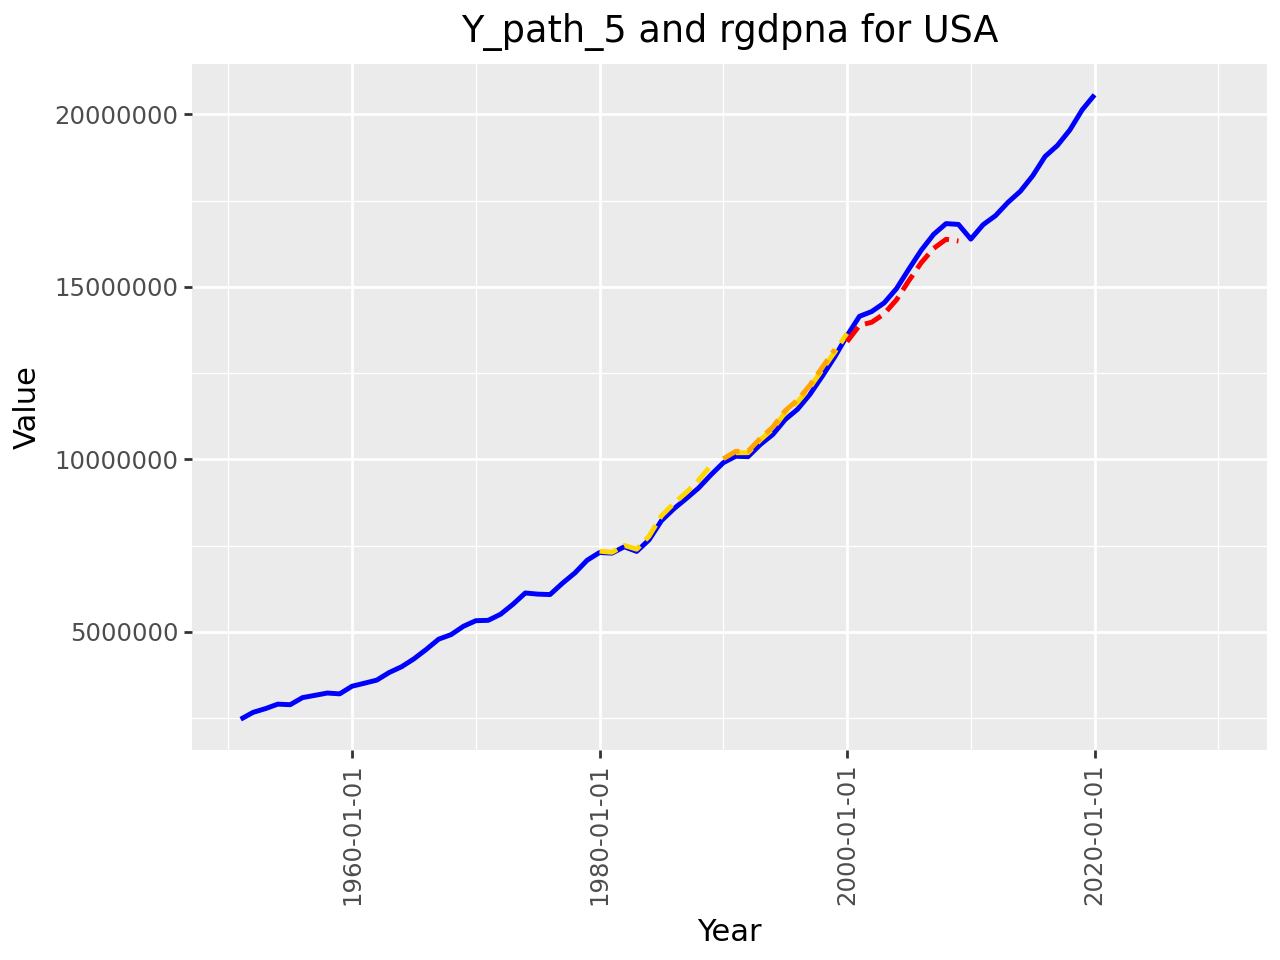

In [680]:
# Plot
plot = (
    ggplot(full_df, aes(x='date')) +

    # Line 2: rgdpna
    geom_line(
        aes(y='rgdpna'),
        color='blue',
        size=1,
        linetype='solid'
    ) +
    # Line 1: Y_path_j
    geom_line(
        aes(y=f'Y_path_1'),
        color='gold',
        size=1,
        linetype='dashed'
    ) +

    geom_line(
        aes(y=f'Y_path_2'),
        color='orange',
        size=1,
        linetype='dashed'
    ) +

    geom_line(
        aes(y=f'Y_path_3'),
        color='red',
        size=1,
        linetype='dashed'
    ) +

    
    labs(
        title=f'Y_path_{j} and rgdpna for {focus_country}',
        x='Year',
        y='Value',
        color='Variable',
        linetype='Variable'
    ) +
    theme(
        axis_text_x=element_text(rotation=90, ha='center')
    ) +
    guides(linetype=None)
)
display(plot)

### Plot the Rolling Forecasts

In [698]:
#  Melt the data
value_vars = [f'Y_path_{i}' for i in range(1, 5)] + ['rgdpna']
long_df = full_df.melt(id_vars=['date'], value_vars=value_vars,
                       var_name='variable', value_name='value')

# Drop rows with missing values
long_df = long_df.dropna(subset=['value'])

# Define manual colors in a mapping that can be used by plotnine
color_map = {
    'rgdpna': 'blue',
    'Y_path_1': '#FFD700',  # gold
    'Y_path_2': '#FFA500',  # orange
    'Y_path_3': '#FF8C00',  # dark orange
    'Y_path_4': '#FF4500'  # orange-red
}

# define manual linetypes in a mapping that can be used by plotnine
linetype_map = {
    'rgdpna': 'solid',
    'Y_path_1': 'dashed',
    'Y_path_2': 'dashed',
    'Y_path_3': 'dashed',
    'Y_path_4': 'dashed'
}

# Map variables to their labels
label_map = {
    'Y_path_1': '1980 forecast',
    'Y_path_2': '1990 forecast',
    'Y_path_3': '2000 forecast',
    'Y_path_4': '2010 forecast',
    'rgdpna': 'Real GDP'
}


In [696]:
long_df.loc[long_df.date == pd.to_datetime('1990-12-31'),:]

,date,variable,value
40,1990-12-31,Y_path_1,1.019017e+07
120,1990-12-31,Y_path_2,1.022956e+07
360,1990-12-31,rgdpna,1.008756e+07


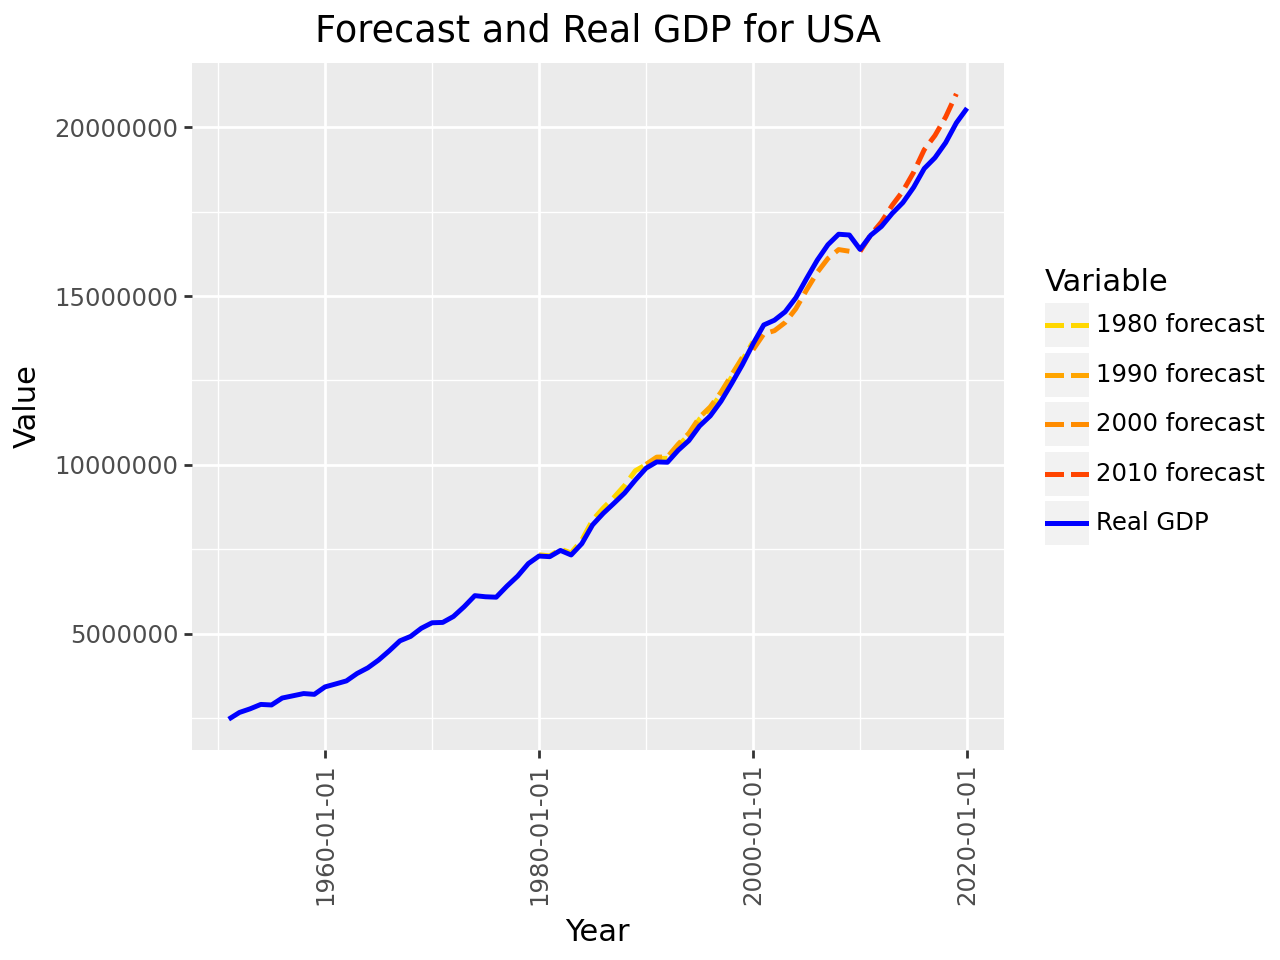

In [701]:
# Actually PLot the plot
plot = (
    ggplot(long_df, aes(x='date', y='value', color='variable', linetype='variable')) +
    geom_line(size=1) +
    scale_color_manual(values=color_map, labels = label_map) +
    scale_linetype_manual(values=linetype_map, labels = label_map) +
    labs(
        title=f'Forecast and Real GDP for {focus_country}',
        x='Year',
        y='Value',
        color='Variable',
        linetype='Variable'
    ) +
    theme(
        axis_text_x=element_text(rotation=90, ha='center'),
        legend_position='right'
    ) +
    guides(linetype=None)  # Remove linetype legend if desired
)

display(plot)